Start by creating a new `conda` environment:

```bash
$ conda create -n pyannote python=3.6 anaconda
$ source activate pyannote
```

Then, install `pyannote-video` and its dependencies:

```bash
$ pip install pyannote-video
```

Finally, download sample video and `dlib` models:

```bash
$ git clone https://github.com/pyannote/pyannote-data.git
$ git clone https://github.com/davisking/dlib-models.git
$ bunzip2 dlib-models/dlib_face_recognition_resnet_model_v1.dat.bz2
$ bunzip2 dlib-models/shape_predictor_68_face_landmarks.dat.bz2
```

To execute this notebook locally:
```bash
$ git clone https://github.com/pyannote/pyannote-video.git
$ jupyter notebook --notebook-dir="pyannote-video/doc"
```


In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Shot segmentation

In [5]:
!pyannote-structure.py --help

Video structure

The standard pipeline for is the following:

    shot boundary detection ==> shot threading ==> segmentation into scenes

Usage:
  pyannote-structure.py shot [options] <video> <output.json>
  pyannote-structure.py thread [options] <video> <shot.json> <output.json>
  pyannote-structure.py scene [options] <video> <thread.json> <output.json>
  pyannote-structure.py (-h | --help)
  pyannote-structure.py --version

Options:
  --height=<n_pixels>    Resize video frame to height <n_pixels> [default: 50].
  --window=<n_seconds>   Apply median filtering on <n_seconds> window [default: 2.0].
  --threshold=<value>    Set threshold to <value> [default: 1.0].
  --min-match=<n_match>  Set minimum number of matches to <n_match> [default: 20].
  --lookahead=<n_shots>  Look at up to <n_shots> following shots [default: 24].
  -h --help              Show this screen.
  --version              Show version.
  --verbose              Show progress.


In [7]:
!pyannote-structure.py shot --verbose ../../pyannote-data/TheBigBangTheory.mkv \
                                      ../../pyannote-data/TheBigBangTheory.shots.json

752frames [00:32, 23.2frames/s]                                                 


Detected shot boundaries can be visualized using `pyannote.core` notebook support:

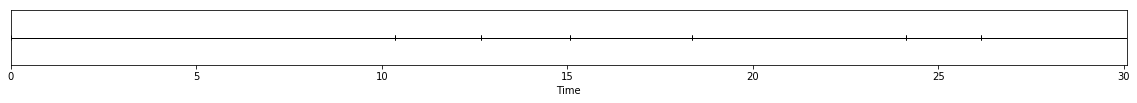

In [8]:
from pyannote.core.json import load_from
shots = load_from('../../pyannote-data/TheBigBangTheory.shots.json')
shots

# Face processing

In [9]:
!pyannote-face.py --help

Face detection and tracking

The standard pipeline is the following

      face tracking => feature extraction => face clustering

Usage:
  pyannote-face track [options] <video> <shot.json> <tracking>
  pyannote-face extract [options] <video> <tracking> <landmark_model> <embedding_model> <landmarks> <embeddings>
  pyannote-face demo [options] <video> <tracking> <output>
  pyannote-face (-h | --help)
  pyannote-face --version

General options:

  -h --help                 Show this screen.
  --version                 Show version.
  --verbose                 Show processing progress.

Face tracking options (track):

  <video>                   Path to video file.
  <shot.json>               Path to shot segmentation result file.
  <tracking>                Path to tracking result file.

  --min-size=<ratio>        Approximate size (in video height ratio) of the
                            smallest face that should be detected. Default is
                            to try and detect any

### Face tracking

In [10]:
!pyannote-face.py track --verbose --every=0.5 ../../pyannote-data/TheBigBangTheory.mkv \
                                              ../../pyannote-data/TheBigBangTheory.shots.json \
                                              ../../pyannote-data/TheBigBangTheory.track.txt

752frames [00:23, 32.0frames/s]                                                 


Face tracks can be visualized using `demo` mode:

In [12]:
!pyannote-face.py demo ../../pyannote-data/TheBigBangTheory.mkv \
                       ../../pyannote-data/TheBigBangTheory.track.txt \
                       ../../pyannote-data/TheBigBangTheory.track.mp4

[MoviePy] >>>> Building video ../../pyannote-data/TheBigBangTheory.track.mp4
[MoviePy] Writing audio in TheBigBangTheory.trackTEMP_MPY_wvf_snd.mp3
100%|████████████████████████████████████████| 664/664 [00:01<00:00, 425.86it/s]
[MoviePy] Done.
[MoviePy] Writing video ../../pyannote-data/TheBigBangTheory.track.mp4
100%|████████████████████████████████████████▉| 752/753 [00:08<00:00, 87.38it/s]
[MoviePy] Done.
[MoviePy] >>>> Video ready: ../../pyannote-data/TheBigBangTheory.track.mp4 



In [14]:
import io
import base64
from IPython.display import HTML
video = io.open('../../pyannote-data/TheBigBangTheory.track.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii')))

### Facial landmarks and face embedding

In [15]:
!pyannote-face.py extract --verbose ../../pyannote-data/TheBigBangTheory.mkv \
                                    ../../pyannote-data/TheBigBangTheory.track.txt \
                                    ../../dlib-models/shape_predictor_68_face_landmarks.dat \
                                    ../../dlib-models/dlib_face_recognition_resnet_model_v1.dat \
                                    ../../pyannote-data/TheBigBangTheory.landmarks.txt \
                                    ../../pyannote-data/TheBigBangTheory.embedding.txt

752frames [00:24, 30.4frames/s]                                                 


### Face clustering

Once embeddings are extracted, let's apply face track hierarchical agglomerative clustering.  
The distance between two clusters is defined as the average euclidean distance between all embeddings.  

In [16]:
from pyannote.video.face.clustering import FaceClustering
clustering = FaceClustering(threshold=0.6)

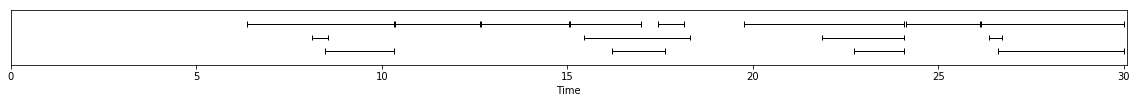

In [17]:
face_tracks, embeddings = clustering.model.preprocess('../../pyannote-data/TheBigBangTheory.embedding.txt')
face_tracks.get_timeline()

In [18]:
result = clustering(face_tracks, features=embeddings)

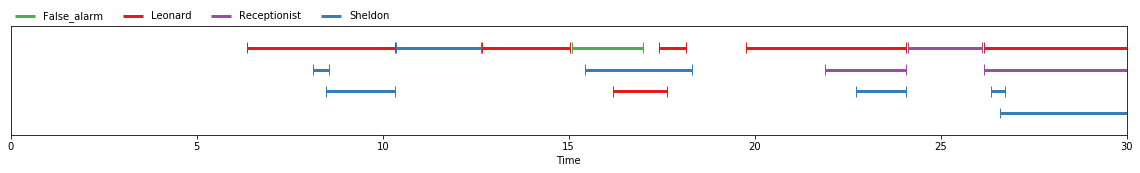

In [19]:
from pyannote.core import notebook, Segment
notebook.reset()
notebook.crop = Segment(0, 30)
mapping = {9: 'Leonard', 6: 'Sheldon', 14: 'Receptionist', 5: 'False_alarm'}
result = result.rename_labels(mapping=mapping)
result

In [21]:
with open('../../pyannote-data/TheBigBangTheory.labels.txt', 'w') as fp:
    for _, track_id, cluster in result.itertracks(yield_label=True):
        fp.write(f'{track_id} {cluster}\n')

In [23]:
!pyannote-face.py demo ../../pyannote-data/TheBigBangTheory.mkv \
                       ../../pyannote-data/TheBigBangTheory.track.txt \
                       --label=../../pyannote-data/TheBigBangTheory.labels.txt \
                       ../../pyannote-data/TheBigBangTheory.final.mp4

[MoviePy] >>>> Building video ../../pyannote-data/TheBigBangTheory.final.mp4
[MoviePy] Writing audio in TheBigBangTheory.finalTEMP_MPY_wvf_snd.mp3
100%|████████████████████████████████████████| 664/664 [00:01<00:00, 411.21it/s]
[MoviePy] Done.
[MoviePy] Writing video ../../pyannote-data/TheBigBangTheory.final.mp4
100%|████████████████████████████████████████▉| 752/753 [00:08<00:00, 87.43it/s]
[MoviePy] Done.
[MoviePy] >>>> Video ready: ../../pyannote-data/TheBigBangTheory.final.mp4 



In [25]:
import io
import base64
from IPython.display import HTML
video = io.open('../../pyannote-data/TheBigBangTheory.final.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii')))